In [3]:
import os
import librosa
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import spectrogram, find_peaks
from scipy.io import wavfile
import pandas as pd
import torch.nn as nn
import torch
import copy
import numpy as np
import torch.optim as optim
import tqdm

In [16]:
class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(14, 128)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(128, 32)
        self.act2 = nn.ReLU()
        self.output = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.2)
        

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.dropout(x)
        x = self.sigmoid(self.output(x))
        return x

In [4]:
df=pd.read_csv('dataframe.csv')

In [5]:
columns2 = ['Min','Max','Harmonic number 1',
       'Harmonic number 2', 'Harmonic number 3', 'Harmonic number 4',
       'Harmonic number 5', 'Harmonic number 6', 'Harmonic number 7',
       'Harmonic number 8','Int 1','Int 2','Int 3','Int 4']
dftr=df[columns2].to_numpy()
dftry=df["Output"].to_numpy()

In [19]:
def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    n_epochs = 200   # number of epochs to run
    batch_size = 5  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None

    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

In [20]:
xdf = torch.tensor(dftr, dtype=torch.float32)
ydf = torch.tensor(dftry, dtype=torch.float32).reshape(-1, 1)

In [30]:
from sklearn.model_selection import StratifiedKFold, train_test_split
X_train, X_test, y_train, y_test = train_test_split(xdf, ydf, train_size=0.85, shuffle=True)

In [27]:
# define 2-fold cross validation test harness
kfold = StratifiedKFold(n_splits=2, shuffle=True)
cv_scores_wide = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = Deep()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    #print("Accuracy (wide): %.2f" % acc)
    cv_scores_wide.append(acc)

In [31]:
print("Accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(cv_scores_wide)*100, np.std(cv_scores_wide)*100))

Accuracy: 63.01% (+/- 1.10%)


In [11]:
from torchsummary import summary

summary(model)

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            1,920
├─ReLU: 1-2                              --
├─Linear: 1-3                            4,128
├─ReLU: 1-4                              --
├─Linear: 1-5                            33
├─Sigmoid: 1-6                           --
├─Dropout: 1-7                           --
Total params: 6,081
Trainable params: 6,081
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            1,920
├─ReLU: 1-2                              --
├─Linear: 1-3                            4,128
├─ReLU: 1-4                              --
├─Linear: 1-5                            33
├─Sigmoid: 1-6                           --
├─Dropout: 1-7                           --
Total params: 6,081
Trainable params: 6,081
Non-trainable params: 0

In [12]:
model

Deep(
  (layer1): Linear(in_features=14, out_features=128, bias=True)
  (act1): ReLU()
  (layer2): Linear(in_features=128, out_features=32, bias=True)
  (act2): ReLU()
  (output): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [6]:
train_X, val_X, train_y, val_y = train_test_split(df[columns2], df["Output"], test_size=0.20, random_state=0)
train_X.head()

,Min,Max,Harmonic number 1,Harmonic number 2,Harmonic number 3,Harmonic number 4,Harmonic number 5,Harmonic number 6,Harmonic number 7,Harmonic number 8,Int 1,Int 2,Int 3,Int 4
824,155.0,2225.0,221.0,278.0,311.0,370.0,442.0,467.0,556.0,835.0,1.257919,1.118705,1.189711,1.194595
262,124.0,1980.0,124.0,248.0,311.0,392.0,467.0,495.0,588.0,742.0,2.000000,1.254032,1.260450,1.191327
624,117.0,2309.0,117.0,234.0,278.0,350.0,556.0,625.0,659.0,835.0,2.000000,1.188034,1.258993,1.588571
122,99.0,1980.0,99.0,175.0,197.0,247.0,312.0,350.0,495.0,742.0,1.767677,1.125714,1.253807,1.263158
561,98.0,994.0,165.0,196.0,233.0,278.0,331.0,496.0,556.0,662.0,1.187879,1.188776,1.193133,1.190647


In [8]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(dftr, dftry, test_size=0.1, random_state=42)

xgb = XGBClassifier()

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Model information:", xgb)

Accuracy: 0.872093023255814
Model information: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


<AxesSubplot: >

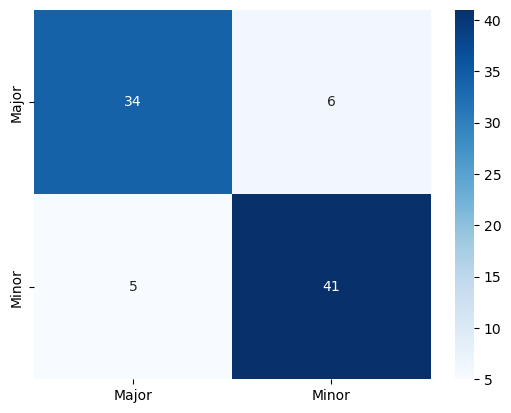

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate predictions
y_pred = xgb.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
sns.heatmap(cm,  annot=True, fmt='d', cmap='Blues',xticklabels=['Major','Minor'], yticklabels=['Major','Minor'])